# 課題
**犬猫の判別**

In [4]:
import numpy as np
import cupy as cp
import matplotlib.pyplot as plt
import seaborn as sns

import chainer
import chainer.links as L
import chainer.functions as F
from chainer import cuda
from chainer import optimizers
from chainer import iterators
from chainer import training
from chainer.training import extensions
from chainer import datasets
from chainer.datasets import TransformDataset
from chainer.datasets import LabeledImageDataset
from functools import partial
from chainercv import transforms

## Dataset作成
preprocess.ipynbで中央部分を224\*224にクロップしたものを画像として保存し、ラベルとしてcsvファイルを作成した。
猫：１、犬：０でラベルづけされている。
訓練時に、ランダムクロップとランダムフリップ、PCA_lightingを犬にのみ行なっている。

In [5]:
train = LabeledImageDataset('./simple_crop/train_data/train_label.csv',
                            './simple_crop/train_data/images/',dtype=np.float32)
test = LabeledImageDataset('./simple_crop/test_data/test_label.csv',
                            './simple_crop/test_data/images/',dtype=np.float32)

def transform(data, train='False'):
    img, label = data
    img = img.copy()

    # Color augmentation
    if train and label==0:
        img = transforms.pca_lighting(img, 76.5)

    # Random flip & crop
    if train and label==0:
        img = transforms.random_flip(img, x_random=True)
        img = transforms.random_expand(img, max_ratio=1.5)
        img = transforms.random_crop(img, (200, 200))
    img=np.array(img, dtype=np.float32)
    img=L.model.vision.vgg.prepare(img)

    return img, label

train_dataset = TransformDataset(train, partial(transform, train=True))
test_dataset = TransformDataset(test, partial(transform, train=False))

## Modelの作成
finetuneされたVGGを使用した。
fc7にfc(dim=2)を追加し、損失関数としてL2 normalizeされたsoftmax cross entropyを用いた。
Scalaとして最も精度が出ていた50を用いた。

In [46]:
class Model(chainer.Chain):
    def __init__(self, dim=2):
        super(Model, self).__init__()
        with self.init_scope():
            self.vgg=L.VGG16Layers()
            self.fc=L.Linear(None, dim)
            
    def __call__(self, x, train=False):
        with chainer.using_config('train', train):
            h=self.vgg(x, layers=['fc7'])['fc7']
            h=F.normalize(h)*50 #L2 normalize + scala
            y=self.fc(h)
        return y
    
class SoftMaxEntoropyLoss(chainer.Chain):
    def __init__(self, model):
        super(SoftMaxEntoropyLoss, self).__init__()
        with self.init_scope():
            self.model = model

    def __call__(self, x, t):
        y = self.model(x)
        y = F.normalize(y)
        loss = F.softmax_cross_entropy(y, t)
        #各種記録用
        accuracy = F.accuracy(y, t)
        summary = F.classification_summary(y, t, beta = 1.0)
        precision = summary[0]
        recall = summary[1]
        f_value = summary[2]
        precision_dict=dict(('precision_%d' % i, val) for i, val in enumerate(summary[0]))
        recall_dict=dict(('recall_%d' % i, val) for i, val in enumerate(summary[1]))
        f_value_dict=dict(('f_value_%d' % i, val) for i, val in enumerate(summary[2]))
        main_dict={'loss':loss, 'accuracy':accuracy}
        main_dict.update(precision_dict)
        main_dict.update(recall_dict)
        main_dict.update(f_value_dict)
        chainer.report(main_dict, self)
        return loss

In [47]:
model=Model()
loss=SoftMaxEntoropyLoss(model)

## ハイパーパラメータの設定
- epoch = 10  
- batchsize = 32  
- MomentumSDG  
- lr=1e-4  

In [48]:
n_epoch = 10
batchsize = 32
out_dir = './result/'
report_interval = (10, 'iteration')

train_iter = iterators.MultithreadIterator\
(train_dataset, batchsize, repeat=True, shuffle=True)

In [49]:
optimizer = chainer.optimizers.MomentumSGD(lr=1e-4)
optimizer.setup(loss)

In [50]:
#device=0でGPU, device=-1でCPU
updater = training.StandardUpdater(train_iter, optimizer, device=0)

In [51]:
trainer = training.Trainer(updater, (n_epoch, 'epoch'), out=out_dir)

trainer.extend(extensions.LogReport(trigger=report_interval))
trainer.extend(extensions.PrintReport(['epoch', 
                                       'iteration', 
                                       'main/loss',
                                       'main/accuracy', 
                                       'main/precision_0', 
                                       'main/precision_1',
                                       'main/recall_0',
                                       'main/recall_1']),
               trigger=report_interval)
trainer.extend(extensions.PlotReport(y_keys='main/loss', trigger=report_interval, file_name='vgg16_loss_plot_catdog.png'))
trainer.extend(extensions.PlotReport(y_keys='main/accuracy', trigger=report_interval, file_name='vgg16_accuracy_plot_catdog.png'))

In [ ]:
trainer.run()

epoch       iteration   main/loss   main/accuracy  main/precision_0  main/precision_1  main/recall_0  main/recall_1
0           10          0.62579     0.659375       nan               0.909757          nan            0.670364       
0           20          0.276848    0.9625         nan               0.9625            nan            1              
0           30          0.284873    0.953125       nan               0.953125          nan            1              
0           40          0.257195    0.971875       nan               0.971875          nan            1              
0           50          0.282912    0.953125       nan               0.953125          nan            1              
0           60          0.239509    0.984375       nan               0.984375          nan            1              
1           70          0.270466    0.9625         nan               0.9625            nan            1              
1           80          0.277747    0.95625        nan    

In [13]:
# save
#chainer.serializers.save_npz('./intern2019_finetune_submit.model', model)

## Evaluate

### 評価用データの準備
評価用データを全部モデルに入力するとMemory Errorを起こすので一つずつモデルに入力させている

In [14]:
X = []
T = []
for x, t in test_dataset:
    X.append(x)
    T.append(t)

X = cp.array(X,dtype=np.float32).reshape(-1, 3, 224, 224)
T = np.array(T,dtype=np.int32)

In [15]:
Y=[]
for i in range(len(X)):
    Y.append([chainer.cuda.to_cpu(model(X[i].reshape(1,3,224,224)).data[0][0]),
              chainer.cuda.to_cpu(model(X[i].reshape(1,3,224,224)).data[0][1])]) #cpuで演算できるようにする
Y=np.array(Y)

### 結果のプロット
- labelづけのみ
- 単純な大小比較
- 原点からの距離による比較

In [16]:
sns.set()
sns.set_style('whitegrid')
sns.set_palette("winter_r", 8, 1)

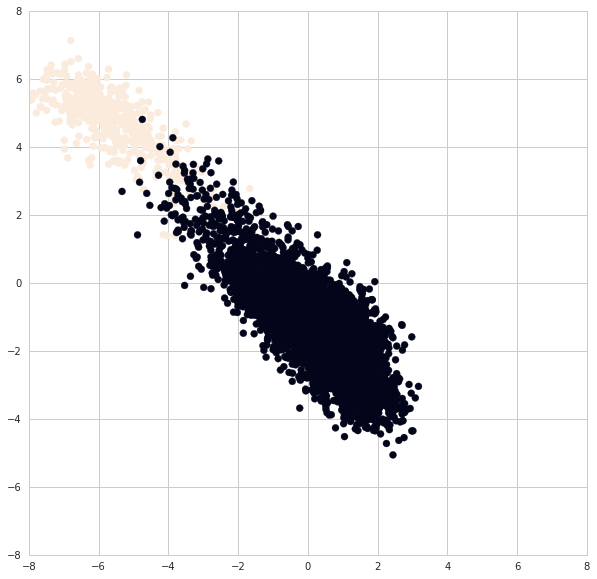

In [17]:
#labelづけ
plt.figure(figsize=(10, 10))
plt.scatter(Y[:,0], Y[:,1],c=T)
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.savefig('labeled_scatter.png')

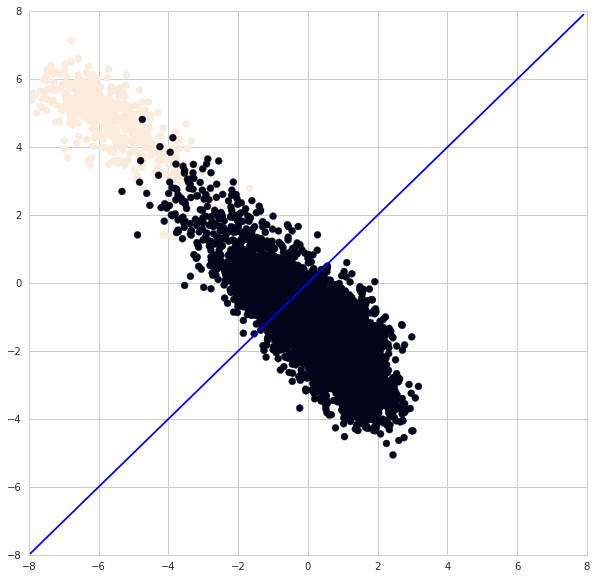

In [18]:
#大小比較
x=np.arange(-8,8,0.1)
y=x
plt.figure(figsize=(10, 10))
plt.scatter(Y[:,0], Y[:,1],c=T)
plt.plot(x,y,c='blue')
plt.xlim(-8,8)
plt.ylim(-8,8)
plt.savefig('LD_labeled_scatter.png')

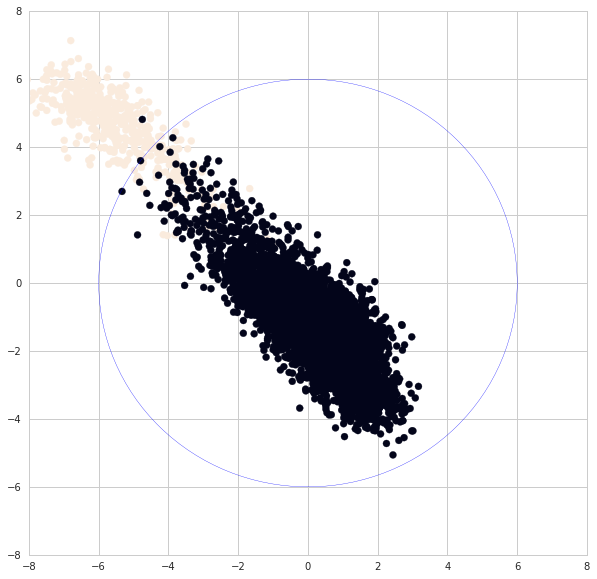

In [19]:
#原点からの距離
import matplotlib.patches as pat
fig=plt.figure(figsize=(10, 10))
ax=fig.add_subplot(111)
ax.scatter(Y[:,0], Y[:,1],c=T)
c = pat.Circle(xy = (0, 0), radius = 6, color = "blue", fill=False)
ax.add_patch(c)
ax.set_xlim(-8,8)
ax.set_ylim(-8,8)
plt.savefig('distance_labeled_scatter.png')

### recall, precision等の検証

In [34]:
def get_stat(result_array, test_label, distance=1, ifPrint=True):
    tp,tn,fp,fn=0,0,0,0
    distance_from_origin=np.sqrt(np.sum(result_array**2, axis=1))
    result_label=distance_from_origin<distance
    if len(result_array)!=len(test_label):
        raise ValueError('different dimension')
    else:
        for i in range(len(test_label)):
            if test_label[i]==0 and result_label[i]==True:
                tp+=1
            elif test_label[i]!=0 and result_label[i]==True:
                fp+=1
            elif test_label[i]==0 and result_label[i]!=True:
                fn+=1
            else:
                tn+=1
    recall=tp/(tp+fn)
    precision=tp/(tp+fp)
    specificity=tn/(fp+tn)
    accuracy=(tp+tn)/(tp+tn+fp+fn)    
    if ifPrint:
        print('distance =',distance)
        print('TP:', tp, ' FP:', fp, ' TN:', tn, 'FN', fn)
        print('recall:', recall)
        print('precision', precision)
        print('specificity:', specificity)
        print('accuracy:', accuracy)
    else:
        return recall, precision, specificity, accuracy

#### recall > 0.999のときのclssification summaryを表示

In [39]:
distance=0.1
while(True):
    ifPrint=False
    tmp_recall, tmp_precision, tmp_specificity, tmp_accuracy=get_stat(Y,T,distance, ifPrint=ifPrint)
    if tmp_recall>0.999:
        ifPrint=True
        get_stat(Y,T,distance,ifPrint=ifPrint)
        break
    distance+=0.01

distance = 5.769999999999921
TP: 4903  FP: 91  TN: 384 FN 4
recall: 0.9991848379865498
precision 0.9817781337605126
specificity: 0.8084210526315789
accuracy: 0.9823485693050911


#### precision reacall curveを書く

In [40]:
def get_recall_and_precision_value(result_array, test_label, distance=1):
    tp,tn,fp,fn=0,0,0,0
    distance_from_origin=np.sqrt(np.sum(result_array**2, axis=1))
    result_label=distance_from_origin<distance
    if len(result_array)!=len(test_label):
        raise ValueError('different dimension')
    else:
        for i in range(len(test_label)):
            if test_label[i]==0 and result_label[i]==True:
                tp+=1
            elif test_label[i]!=0 and result_label[i]==True:
                fp+=1
            elif test_label[i]==0 and result_label[i]!=True:
                fn+=1
            else:
                tn+=1
    recall=tp/(tp+fn)
    precision=tp/(tp+fp)
    return recall, precision

In [41]:
chance_rate=len(T[T==0]) / len(T)
print(chance_rate)

0.9117428465254552


In [42]:
recall_list,precision_list=[],[]
distance=0.1
while(True):
    distance+=0.1
    tmp_recall, tmp_precision=get_recall_and_precision_value(Y,T,distance=distance)
    if tmp_precision==chance_rate:
        break
    recall_list.append(tmp_recall)
    precision_list.append(tmp_precision)

chance_rate: 0.9117428465254552


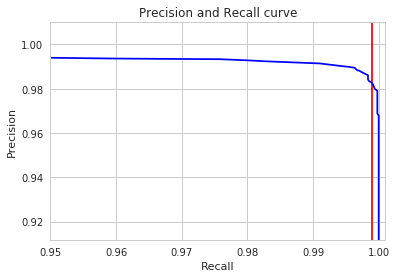

In [43]:
print('chance_rate:', chance_rate)
p=np.array(recall_list)
r=np.array(precision_list)
plt.plot(p,r,c='blue')
plt.title('Precision and Recall curve')
plt.vlines(0.999,1.01,0,'red')
plt.ylim(chance_rate,1.01)
plt.xlim(0.95,1.001)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.savefig('precision_and_recall.png')